<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Simpsons_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('images'):
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d ymalov/simpsons
    !unzip -qq simpsons.zip
    !rm simpsons.zip

Saving kaggle.json to kaggle.json
kaggle.json
 99% 553M/558M [00:10<00:00, 72.8MB/s]
100% 558M/558M [00:10<00:00, 56.7MB/s]


In [33]:
!pip install git+https://github.com/tensorflow/docs

import os
import pathlib
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import Model
AUTOTUNE = tf.data.experimental.AUTOTUNE

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-15ysrs7_
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-15ysrs7_
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.07b5d9bbaa2587be9c80da5d50817ab3e25024a28_-cp37-none-any.whl size=153744 sha256=922e7bf61e95cd15daf687495bfdcd8f424926ebcaed5e90f8767b334a29c087
  Stored in directory: /tmp/pip-ephem-wheel-cache-3hn4pp5k/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
def plot_model_history(model_history, metric, plot_name):
    plt.style.use('seaborn-darkgrid')
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({'Model': model_history}, metric=metric)

    plt.title(f'{metric.upper()}')
    plt.ylim([0, 1])

    plt.savefig(f'{plot_name}.png')
    plt.close()

def load_image_and_label(image_path, target_size=(128,128)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, np.float32)
  image = tf.image.resize(image, target_size)

  label = tf.strings.split(image_path, os.path.sep)[-2]
  label = (label == CLASSES)
  label = tf.dtypes.cast(label, tf.float32)

  return image, label

def augment(image, label):
  image = tf.image.resize_with_crop_or_pad(image, 148, 148)
  image = tf.image.random_crop(image, size=(128,128,3))
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, 0.2)

  return image, label

def prepare_dataset(data_pattern):
  return (tf.data.Dataset.from_tensor_slices(data_pattern).map(load_image_and_label, num_parallel_calls=AUTOTUNE))

In [4]:
SEED = 999
np.random.seed(SEED)

base_path = (pathlib.Path.cwd() / 'train')
images_pattern = str(base_path/ '*_simpson' / '*.jpg')
images_paths = [*glob(images_pattern)]
CLASSES = np.unique([p.split(os.path.sep)[-2]
                     for p in images_paths])

train_paths, test_paths = train_test_split(images_paths,
                                           test_size=0.2,
                                           random_state=SEED)

In [5]:
def build_network(width, height, depth, classes):
    input_layer = Input(shape=(width, height, depth))

    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               padding='same')(input_layer)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.25)(x)

    x = Flatten()(x)
    x = Dense(units=512)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(rate=0.5)(x)

    x = Dense(units=classes)(x)
    output = Softmax()(x)

    return Model(input_layer, output)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

train_dataset = (prepare_dataset(train_paths).batch(BATCH_SIZE).shuffle(buffer_size=BUFFER_SIZE).prefetch(buffer_size=BUFFER_SIZE))
test_dataset = (prepare_dataset(test_paths).batch(BATCH_SIZE).shuffle(buffer_size=BUFFER_SIZE).prefetch(buffer_size=BUFFER_SIZE))

EPOCHS = 5
model = build_network(128,128,3, len(CLASSES))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs=EPOCHS)

result = model.evaluate(test_dataset)
print(f'Test_accuracy: {result[1]}')
plot_model_history(history, 'accuracy', 'normal')

Epoch 1/5
91/91 [==============================] - 22s 131ms/step - loss: 1.5405 - accuracy: 0.5592 - val_loss: 2.3881 - val_accuracy: 0.1704
Epoch 2/5
91/91 [==============================] - 20s 129ms/step - loss: 0.8931 - accuracy: 0.6998 - val_loss: 1.4988 - val_accuracy: 0.3808
Epoch 3/5
91/91 [==============================] - 20s 129ms/step - loss: 0.5772 - accuracy: 0.7965 - val_loss: 2.2500 - val_accuracy: 0.3863
Epoch 4/5
91/91 [==============================] - 20s 128ms/step - loss: 0.3562 - accuracy: 0.8730 - val_loss: 1.5531 - val_accuracy: 0.4818
Epoch 5/5
23/23 [==============================] - 3s 21ms/step - loss: 1.1772 - accuracy: 0.6474
Test_accuracy: 0.6474226713180542


In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

train_dataset = (prepare_dataset(train_paths).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).shuffle(buffer_size=BUFFER_SIZE).prefetch(buffer_size=BUFFER_SIZE))
test_dataset = (prepare_dataset(test_paths).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).shuffle(buffer_size=BUFFER_SIZE).prefetch(buffer_size=BUFFER_SIZE))

EPOCHS = 10
model = build_network(128,128,3, len(CLASSES))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs=EPOCHS)

result = model.evaluate(test_dataset)
print(f'Test_accuracy: {result[1]}')
plot_model_history(history, 'accuracy', 'augmented')

Epoch 1/10
91/91 [==============================] - 23s 133ms/step - loss: 1.6999 - accuracy: 0.5046 - val_loss: 3.0491 - val_accuracy: 0.2687
Epoch 2/10
91/91 [==============================] - 21s 131ms/step - loss: 1.1819 - accuracy: 0.6075 - val_loss: 1.6976 - val_accuracy: 0.3842
Epoch 3/10
91/91 [==============================] - 21s 131ms/step - loss: 0.9334 - accuracy: 0.6678 - val_loss: 2.0730 - val_accuracy: 0.3471
Epoch 4/10
91/91 [==============================] - 21s 132ms/step - loss: 0.7794 - accuracy: 0.7237 - val_loss: 1.4816 - val_accuracy: 0.5203
Epoch 5/10
91/91 [==============================] - 22s 132ms/step - loss: 0.6734 - accuracy: 0.7572 - val_loss: 1.2658 - val_accuracy: 0.5052
Epoch 6/10
91/91 [==============================] - 22s 133ms/step - loss: 0.5873 - accuracy: 0.7933 - val_loss: 0.9791 - val_accuracy: 0.6351
Epoch 7/10
91/91 [==============================] - 21s 131ms/step - loss: 0.5066 - accuracy: 0.8214 - val_loss: 0.5863 - val_accuracy: 0.7904

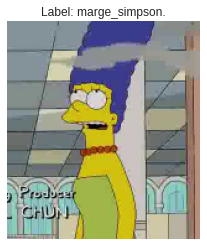

In [38]:
def load_image(image_path, target_size=(128,128)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, np.float32)
  image = tf.image.resize(image, target_size)
  image = tf.expand_dims(image, axis=0)

  return image

image = load_image('/content/testset/img116.jpg')
preds = model.predict(image)

plt.figure()
plt.title(f'Label: {CLASSES[np.argmax(preds)]}.')
original = load_img('/content/testset/img116.jpg')
original = img_to_array(original)
plt.imshow(original / 255.0)
plt.grid(False)
plt.axis('off')
plt.show()